# Probabilistic Planning with MDP


## The confused traveler

Imagine an traveler who wants to drive from a city in the northwest to another one in the northeast. However, it turns out that the traveler forgot his GPS device and all of his printed maps (compared to the lucky guy in the picture below). Our traveler has to completely rely on the street signs in the cities. Unfortunately for him, the signs are much more confusing in the north than in the south. Therefore, it is likelier for him to take the wrong route in the northern part of the country. Given this, the agent wonders what his best strategy is to get from one city to the other while minimizing the distance he needs to go. 

<img src=confused_traveler.jpg>

Let's start by providing him with some helpful imports to start with:

In [69]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Modules
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt

# Classes
from graph import Graph, Edge
from search_classes import SearchNode, Path
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction and problem statement

Before we think about which algorithm we can use to help our traveler, let's model the map that he travels on. To keep things familiar, we will use a derived version of the romania graph. Compared to the original map, we added some additional connections and the weight for each edge is now the euclidian distance between two cities, i.e. the distance our traveler needs to travel. 

Our traveler starts in city 'O' and wants to go to 'N'.

To encode the bad street signs in the north, we made a linear probability distribution between the southmost city 'G' and the northmost city 'O'. We visualized this by coloring the cities from red to green, where red is a high probability of taking the wrong road vice versa for green. 

Execute the following cell to get the graph plotted!

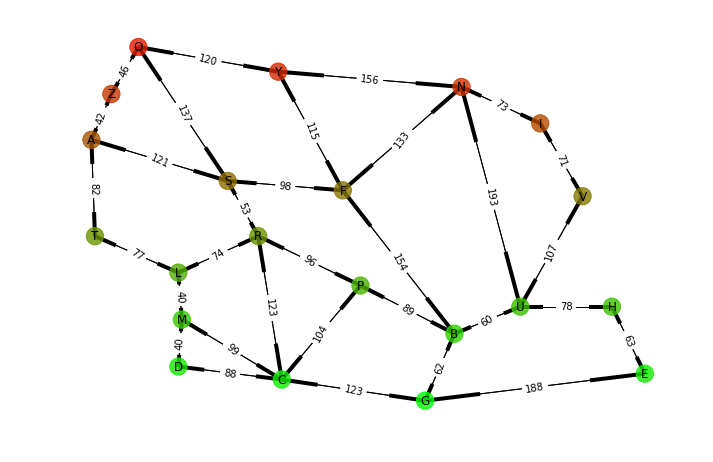

In [70]:
# x,y positions of Romania's cities
romania_locations = dict(
    A=(91, 492), B=(400, 327), C=(253, 288), D=(165, 299),
    E=(562, 293), F=(305, 449), G=(375, 270), H=(534, 350),
    I=(473, 506), L=(165, 379), M=(168, 339), N=(406, 537),
    O=(131, 571), P=(320, 368), R=(233, 410), S=(207, 457),
    T=(94, 410), U=(456, 350), V=(509, 444), Z=(108, 531), Y=(250, 550))

# Initialize connections
romania_connections = dict(
    A=dict(Z=1, S=1, T=1),
    B=dict(U=1, P=1, G=1, F=1),
    C=dict(D=1, R=1, P=1, G=1),
    D=dict(C=1, M=1),
    E=dict(H=1, G=1),
    F=dict(B=1, S=1, N=1, Y=1),
    G=dict(B=1, C=1, E=1),
    H=dict(E=1, U=1),
    I=dict(V=1, N=1),
    L=dict(T=1, M=1, R=1),
    M=dict(C=1, L=1),
    N=dict(F=1, I=1, U=1, Y=1),
    O=dict(Z=1, S=1, Y=1),
    P=dict(B=1, C=1, R=1),
    R=dict(C=1, L=1, S=1, P=1),
    S=dict(A=1, F=1, O=1, R=1),
    T=dict(A=1, L=1),
    U=dict(B=1, H=1, V=1, N=1),
    V=dict(I=1, U=1),
    Z=dict(A=1, O=1),
    Y=dict(O=1, N=1, F=1),
)

# Updates weights with euclidean distance
for connections in romania_connections:
    for destination in romania_connections[connections]:
        romania_connections[connections][destination] = int(
            eucl_dist(romania_locations[connections], romania_locations[destination]))

romania_graph = Graph()

romania_graph.set_node_positions(romania_locations)
for location1 in romania_connections:
    for location2 in romania_connections[location1]:
        romania_graph.add_edge(location1, location2, romania_connections[location1][location2])
        
# Probability of taking the right road
def get_prob(romania_locations, prob_G, prob_O):
    romania_correct_turn = dict()
    for location in romania_locations:
        romania_correct_turn[location] = prob_O + (romania_locations[location][1] - romania_locations['O'][1]) * \
                                         ((prob_O - prob_G) / (romania_locations['O'][1] - romania_locations['G'][1]))
    return romania_correct_turn

romania_correct_turn = get_prob(romania_locations, prob_G = 1, prob_O = 0.1)


# Draw the map
romania_graph.draw(color_keys=romania_correct_turn)

## Encoding the graph as a MDP

To help the traveler, we recall some of the tools we learned in 16.413. After intense discussion what the most appropriate encoding would be, we agreed to use Markov Decision Processes (MDP). The MDP consist of a discrete set of states $S$, a discrete set of actions $A$ that an agent can take to from one state to get to another one, a transition that defines the probabilities of the resulting states where the agent lands if he takes action $a$ from state $s$. 

More formally a MDP is defined by the following four components:
- $S$ discrete set of states
- $A$ discrete set of actions
- $T: SxAxS -> [0,1]$ transition function
- $R: SxA -> R$ reward function

We decided on the MDP as a representation as we can easily encode the cities, the directions the traveler can take and the deviation of the planned direction with the transition function. Reaching the desired city 'N' is rewarded with a reward defined in the reward function. Since the traveler wants to reach the destination with minimizing the distance traveled, we can encode the distance between two cities as an immediate, negative reward.

To summarize, we encode our example in this way:
- cities as **states**,
- the route the traveler wants to take as **actions**,
- the probabilites to end up in the desired city or another one with the **transition** dictionary, if the traveler is in state $s$ and takes action $a$
- and the reward when reaching the destination and the travel distance as **reward** dictionary

Let's build the MDP:

In [79]:
# Build the MDP
def build_mdp(romania_locations, romania_connections, romania_correct_turn, goal_dict, gamma):
    # States
    S = set(location for location in romania_locations)

    # Actions
    A = dict()
    for s in S:
        location = s[0]
        if location in goal_dict:
            A[s] = [location]
        else:
            A[s] = [destination for destination in romania_connections[location]]

    # Transitions
    T = dict()
    for s in S:
        T[s] = dict()
        for action in A[s]:
            T[s][action] = dict()
            for destination in romania_connections[s]:
                if destination == action:
                    T[s][action][destination] = romania_correct_turn[s]
                elif len(romania_connections[s]) > 1: # Split the other prob evenly over the remaining nodes
                    T[s][action][destination] = (1 - romania_correct_turn[s])/(len(romania_connections[s])-1)

    # Reward
    R = dict()
    for location in T:
        R[location] = dict()
        for action in T[location]:
            R[location][action] = dict()
            for destination in T[location][action]:
                if action in goal_dict:
                    R[location][action][destination] = goal_dict[action]
                else:
                    R[location][action][destination] = - romania_connections[location][destination]  # travel cost

    return MDP(S, A, T, R, gamma)

## Get the optimal policies by value iteration

After you have encoded the problem, you finally can write some algorithm to help out our traveler. Since the traveler is really confused, you want to give him an optimal policy for each city that he might be in. You rememeber that one solution to this problem is value iteration. This algorithm iteratively calculates the value function for each state. Based on this an optimal policy can be derived. The optimal value function for an infinite horizon is calucated by the Bellman's Equation:
$$V^*(s) = max_{a' in A} [r(s, a') + \gamma V^*(\delta(s, a'))]$$

where $\gamma$ is the discount factor, $r$ the immediate reward, $\delta$ the transition probability. Value iteration uses the dynamic programming principle of reusing shared sub-results that result in exponential savings. The pseudo code that we implemented in the `utils.py` file reads:

1. Iteratively calculate the Bellman's Equation:
$V^*_{t+1}(s) <- max_{a' in A} [r(s, a') + \gamma V^*_{t}(\delta(s, a'))]$

2. Terminate when values are close enough:
$\mid V^*_{t+1}(s) - V^*_{t}(s) \mid < \epsilon$

After the value iteration terminated each state has a converged value. With this information, we can find an optimal policy for the traveler in each city that directs him to the goal while minimizing distance (maximizing reward). We can do this formally by a one step lookahead. Formally, this reads:

$$\pi^*(s) = argmax_{a' in A}[r(s, a') + \gamma V^*(\delta(s, a'))]$$

What this equation does is finding the best action for each state that maximized the reward. This best action is then called optimal policy $\pi^*$. By using this and tracing it from the start city 'O' to the traveler's destination 'N', we can extract an optimal path (notice that there does not necessarily need to exist a path depending on the reward that is assigned to the goal).

To be as clear as possible and avoid any more confusion of our traveler, we give him a textual description of the optimal policies as well as a graphical depiction of where he needs to go.

Let's see what we get:

The value iteration needed 139 iterations to converge, and explored 2919 states
For R best choice is P
For V best choice is I
For Y best choice is N
For A best choice is S
For S best choice is F
For B best choice is U
For M best choice is C
For Z best choice is A
For P best choice is B
For U best choice is N
For E best choice is H
For H best choice is U
For N best choice is N
For I best choice is N
For G best choice is B
For O best choice is Z
For D best choice is C
For C best choice is G
For L best choice is M
For F best choice is N
For T best choice is L


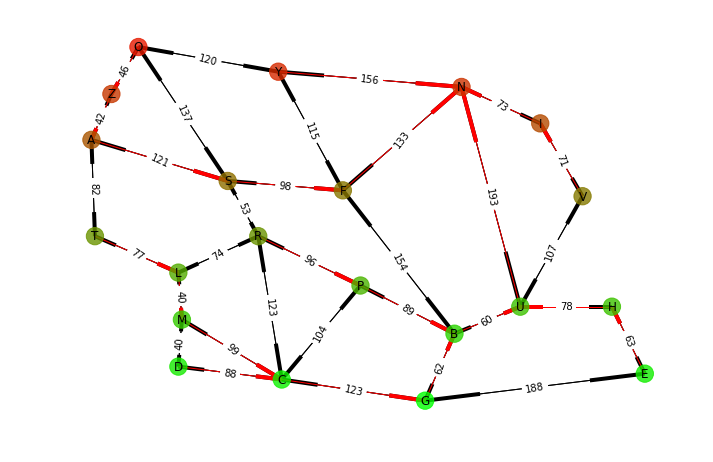

Optimal path: ['O', 'Z', 'A', 'S', 'F', 'N']


In [77]:
def build_mdp_and_get_policies(romania_connections, start, goal_dict):
    # Build mdp
    mdp = build_mdp(romania_locations, romania_connections, romania_correct_turn, goal_dict, gamma=0.9)

    # Value iteration and extract policies
    v, expanded_states = value_iteration(mdp, epsilon=1e-3)
    Pi = extract_policy(mdp, v)
    return Pi, expanded_states


def visualize_optimal_policy(start, Pi, goal_dict, graph, color_keys):
    # Print
    for p in Pi:
        print("For " + p + " best choice is " + Pi[p])

    # Draw optimal policies
    graph.draw(highlight_edges=[(p, Pi[p]) for p in Pi], color_keys=color_keys)

    # Get optimal path
    def get_optimal_path(start, Pi):
        path = [start]
        while True:
            if path[-1] in goal_dict:
                break
            path.append(Pi[path[-1]])
            if len(path) > len(Pi)+1:
                path = "no path found"
                break
        return "Optimal path: " + str(path)

    print(get_optimal_path(start, Pi))


# Init parameters
goal_dict = dict(N=100)
start = 'O'

# Run functions
Pi, expanded_states_VI = build_mdp_and_get_policies(romania_connections, start, goal_dict)
visualize_optimal_policy(start, Pi, goal_dict, romania_graph, romania_correct_turn)

Surprised? Have you expected that? 

Apparently, the obvious shortest path in the north 'O' -> 'Y' -> 'N' is not optimal. It seems the signs are so bad in the north that the probability is very high that the traveler actually ends up in the different city than he wanted to, and therefore accumulates negative rewards (i.e. travelled distance). It will be better for him to do an extra turn to go to the south, where he can be sure that he will make progress and then go back up again. 

You can use the cell below to play around yourself with different combinations of starts, goals, and rewards for the goal

The value iteration needed 112 iterations to converge, and explored 2352 states
For R best choice is P
For V best choice is V
For Y best choice is O
For A best choice is T
For S best choice is R
For B best choice is U
For M best choice is C
For Z best choice is O
For P best choice is B
For U best choice is V
For E best choice is H
For H best choice is U
For N best choice is Y
For I best choice is V
For G best choice is B
For O best choice is S
For D best choice is C
For C best choice is G
For L best choice is M
For F best choice is B
For T best choice is L


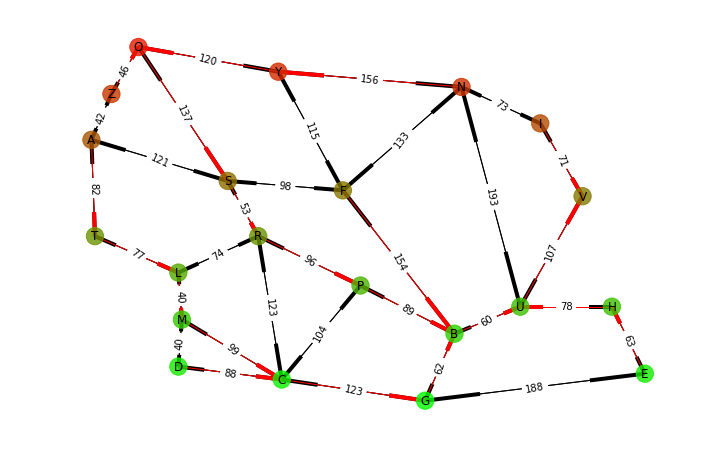

Optimal path: ['T', 'L', 'M', 'C', 'G', 'B', 'U', 'V']


In [73]:
# Init parameters
goal_dict = dict(V=100)
start = 'T'

# Run functions
Pi, expanded_states_VI_V = build_mdp_and_get_policies(romania_connections, start, goal_dict)
visualize_optimal_policy(start, Pi, goal_dict, romania_graph, romania_correct_turn)

## Constructions everywhere - AO* for acyclic graphs
After you worked with your team to setup the MDP and find optimal policies with value iteration, you meet your traveler and want to show him your results. He is very pleased with what you did, however he just found out that there will be numerous constructions going on and that therefore all of the connections are one-way only and therefore the map you developed earlier is no longer valid. Motivated by the new challenge you meet again with your team to find a solution for the new problem. 

<img src=construction.jpg>

In a first step, you update your modeling of the problem and make the connections one-directional only according to the traveler's information. Execute the following cell to see how it looks like:

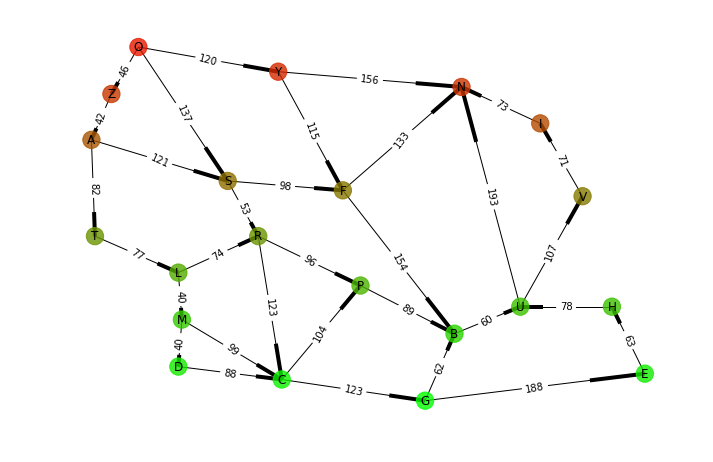

In [103]:
# Rebuild map
romania_connections_dir = dict(
    A=dict(S=1, T=1),
    B=dict(U=1),
    C=dict(P=1, G=1),
    D=dict(C=1),
    E=dict(H=1),
    F=dict(B=1, N=1),
    G=dict(B=1, E=1),
    H=dict(U=1),
    I=dict(N=1),
    L=dict(M=1, R=1),
    M=dict(C=1, D=1),
    N=dict(),
    O=dict(Z=1, S=1, Y=1),
    P=dict(B=1),
    R=dict(C=1, P=1),
    S=dict(F=1, R=1),
    T=dict(L=1),
    U=dict(V=1, N=1),
    V=dict(I=1),
    Z=dict(A=1),
    Y=dict(N=1, F=1),
)

# Updates weights with euclidean distance
for connections in romania_connections_dir:
    for destination in romania_connections_dir[connections]:
        romania_connections_dir[connections][destination] = int(
            eucl_dist(romania_locations[connections], romania_locations[destination]))

romania_graph_dir = Graph()

romania_graph_dir.set_node_positions(romania_locations)
for location1 in romania_connections_dir:
    for location2 in romania_connections_dir[location1]:
        romania_graph_dir.add_edge(location1, location2, romania_connections_dir[location1][location2], bidirectional=False)
# Draw the map
romania_graph_dir.draw(color_keys=romania_correct_turn)

### AO*
In order to solve this problem now, you want to use AO*. This algorithm is similar to the famous A* but adapted for probabilistic planning. We can still use the encoding as a MDP, but will set the discount factor $\gamma$ to 1 (no discounting) and define an admissible heuristic that is an optimistic estimate if the current state to the goal. 

The AO* strategy is to incrementally build a solution forward from the start state. It then expands this state and estimate the future reward with a heuristic. Similar to value-iteration it also backs-up and propagate back the updated estimates of the value function. By simultaniously assessing the best possible action, we get a list of best policies, which often is called a greedy hypergraph g. 

The key idea is to estimate the value function $V^*(s_{k+1})$ with an heuristic $h(s_{k+1})$ such that

$$h(s_{k+1}) \ge V^*(s_{k+1})$$

The first heuristic that you want to use is the euclidian distance to the goal state. You can see the implementation of the AO* algorithm below.

In [110]:
def AO_star(mdp, start, end):

    S, A, T, R = mdp.S, mdp.A, mdp.T, mdp.R

    Q = dict()
    open_nodes = [start]
    g = dict()
    g[start] = None

    # Expansion
    counter = 0
    expanded_nodes = []
    while open_nodes:

        open_node = open_nodes.pop()
        counter += 1
        expanded_nodes.append(open_node)

        if open_node[0] in end:
            return g, expanded_nodes

        Q[open_node] = dict()
        for a in A[open_node]:
            h = dict()
            Q[open_node][a] = 0
            for s_new in T[open_node][a]:
                
                # HEURISTIC
                h[s_new] = - eucl_dist(romania_locations[s_new[0]], romania_locations[end])

            # Update Q function of current open node
            Q[open_node][a] += R[open_node][a][s_new] + h[s_new] * T[open_node][a][s_new]

        # Backup to ancestor of open node
        current_node = open_node
        while True:
            if current_node == start:
                break
            # Find ancestor entry
            for q in Q:
                for a in Q[q]:
                    if a == current_node:
                        ancestor = q
            Q[ancestor][current_node] = Q[current_node][max(Q[current_node], key=Q[current_node].get)]
            current_node = ancestor

        # Select best action and update g
        g = dict()
        for node in Q:
            g[node] = max(Q[node], key=Q[node].get)

        open_nodes.extend(s_new for s_new in T[open_node][g[open_node]])

        if counter >= 1000:
            print("Cannot converge within 1000 iterations, possibly a loop")
            return [], expanded_nodes


**Solve it with AO***
Now, you have developed everything to solve the problem. Compared to the value iteration for the full graph, you now only solve for a defined start and goal destination. Execute the follwing cell to get the results. You will see  that only a hand-full of states need to be expanded compared thousands for the value iterations.

For O best choice is Y
For Y best choice is F
For F best choice is N


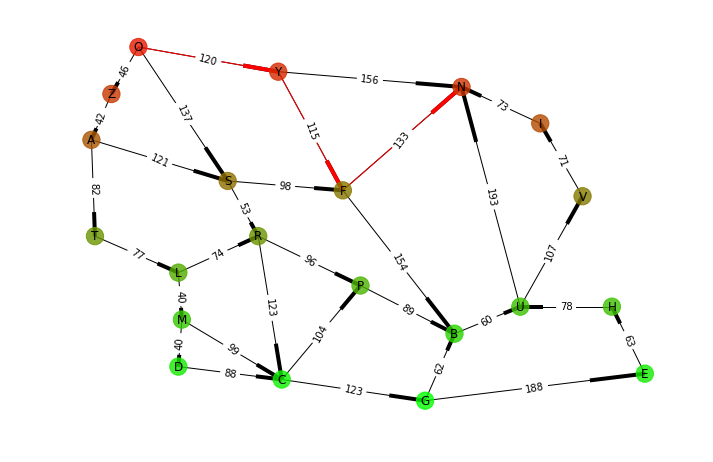

Optimal path: ['O', 'Y', 'F', 'N']
4 nodes were expanded


In [114]:
goal_dict = dict(N=100)
start = 'O'

mdp_dir = build_mdp(romania_locations, romania_connections_dir, romania_correct_turn, goal_dict, gamma=1)

g_AO, expanded_nodes_AOstar = AO_star(mdp_dir, start, max(goal_dict))

visualize_optimal_policy(start, g_AO, goal_dict, romania_graph_dir, romania_correct_turn)
print(str(len(expanded_nodes_AOstar)) + " nodes were expanded")

## Delivery

Finally, when you meet with the confused traveler again and show him the work you did, he is more than pleased. Due to the faster execution, you were able to implement the AO* search for his mobile device, so he can offline recalculate at every city. And in case the constructions are resolved earlier is prepared with the solution from the value iteration MDP!

He right away begins his journey. A few days later he sends you a picture from him reaching his destination and thanks you again for your hard work. Furthermore, you found out that he updated the probabilistic distribution map with his experience as he travelled along. As you now want to commercialize your idea, you already start about the next steps and how you can update those beliefs as more travelers will use your tool...

<img src=happy-traveler.jpg>